## Setup

In [1]:
import os
import sys
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

main dir: /Users/pablo/github/mate


In [3]:
# Internal modules
from pesuelogit.etl import add_period_id
from mate.etl import data_curation

## Read spatiotemporal data

In [4]:
folderpath = 'input/network-data/fresno/links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 3)]
df['year'] = df.date.dt.year

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

In [5]:
# Add period id for timevarying estimation
period_feature = 'hour'
df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


## Data curation

In [6]:
df = data_curation(df)

## Exploratory Data Analysis (EDA)

### Targets

In [7]:
df[['counts_lane', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts_lane,tt_ff,tt_avg,tf_inrix,speed_avg
count,59096.000000,1.013460e+06,887813.000000,1.013460e+06,1.013460e+06
mean,1424.993320,3.397371e-03,0.003658,1.993917e-01,1.873764e+01
std,461.793008,4.350074e-03,0.004367,2.271887e-01,2.026494e+01
min,0.779896,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1110.103562,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
50%,1426.587541,2.495627e-03,0.002784,1.510000e-01,1.817500e+01
75%,1755.912485,4.653995e-03,0.005216,2.770000e-01,2.765100e+01
max,2400.000000,7.034335e-02,0.063791,2.302000e+00,7.565200e+01


In [8]:
df.query('year == 2019')[['counts_lane', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts_lane,tt_ff,tt_avg,tf_inrix,speed_avg
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1488.711817,0.003415,0.003699,0.200169,17.946237
std,462.285984,0.004370,0.004448,0.228208,20.262676
min,0.779896,0.000000,0.000000,0.000000,0.000000
25%,1188.724832,0.000000,0.000000,0.000000,0.000000
50%,1494.280386,0.002508,0.002814,0.152000,16.000000
75%,1823.017903,0.004702,0.005304,0.280000,27.340000
max,2400.000000,0.070343,0.063791,2.302000,75.652000


In [9]:
df.query('year == 2020')[['counts_lane', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts_lane,tt_ff,tt_avg,tf_inrix,speed_avg
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1351.644684,0.003377,0.003613,0.198494,19.650807
std,450.202278,0.004326,0.004275,0.226003,20.229134
min,5.725646,0.000000,0.000000,0.000000,0.000000
25%,1038.280415,0.000000,0.000000,0.000000,0.000000
50%,1347.643221,0.002491,0.002756,0.150000,20.505000
75%,1681.922253,0.004578,0.005112,0.273000,28.117000
max,2400.000000,0.070343,0.054574,2.113000,73.943000


In [10]:
### Variation of average speed and flow between years
table_df = df.groupby(['year'])[['counts_lane', 'speed_avg']].mean()
print(table_df,'\n')
print(table_df.iloc[1]/table_df.iloc[0]-1)

      counts_lane  speed_avg
year                        
2019  1488.711817  17.946237
2020  1351.644684  19.650807 

counts_lane   -0.092071
speed_avg      0.094982
dtype: float64


### Link-level attributes of utility function

In [11]:
features_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

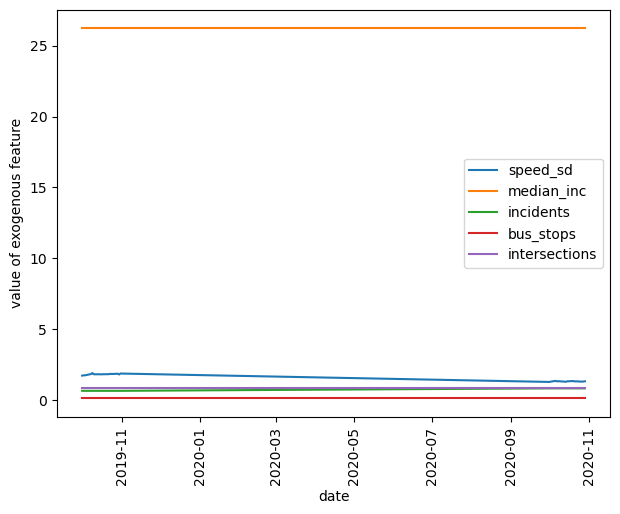

In [12]:
# For visualization purposes, the standard deviation of speed and not of travel time is shown
features_plot = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(df.groupby('date')[features_plot].mean().reset_index(),id_vars= ['date']))
plt.tight_layout()
plt.legend(title="")
plt.ylabel("value of exogenous feature")
plt.xticks(rotation=90)
plt.show()

## Stats by date

In [13]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [14]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts_lane']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts_lane,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1497.588808,36195
2019-10-02,1.760109,17.169768,1476.571607,36195
2019-10-03,1.754288,17.092304,1509.584533,36195
2019-10-08,1.847060,18.165569,1478.300459,36195
2019-10-09,1.917923,18.137042,1481.272743,36195
2019-10-10,1.830232,18.107925,1514.981758,36195
2019-10-15,1.831527,18.114384,1480.838248,36195
2019-10-16,1.823680,18.162625,1486.702565,36195
2019-10-17,1.832219,18.080860,1501.029287,36195


### Cross sectional

In [15]:
# eda_df = df[df.year == 2019].copy()
eda_df = df.copy()
eda_df['day'] = eda_df.date.dt.day
eda_df['hour_id'] = eda_df['hour'].astype(str).apply(lambda x: time.strftime("%l%p", time.strptime(x,"%H")))
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

In [16]:
eda_df['hour_id'] = pd.Categorical(eda_df['hour_id'], categories = eda_df[['hour_id', 'hour']].drop_duplicates().sort_values('hour')['hour_id'], ordered = True)

In [17]:
daily_counts = eda_df.groupby('date')[['counts_lane']].mean().reset_index()
daily_counts['date'] = daily_counts['date'].astype(str)

daily_speed = eda_df.groupby('date')[['speed_avg']].mean().reset_index()
daily_speed['date']  = daily_speed['date'].astype(str)

daily_attributes = pd.melt(eda_df.groupby('date')[features_plot].mean().reset_index(),id_vars= ['date'])
daily_attributes['date']  = daily_attributes['date'].astype(str)

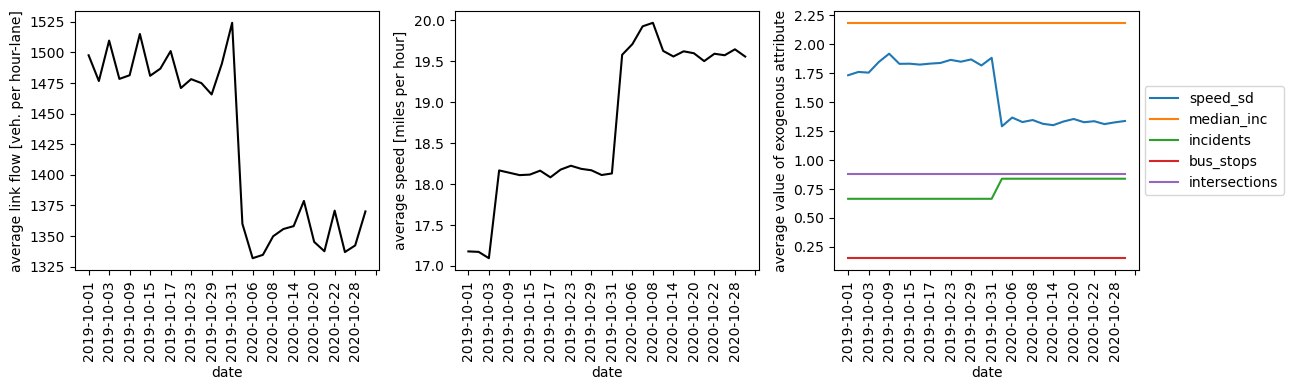

In [18]:
locator = matplotlib.dates.DayLocator(interval = 2)

fig, axs = plt.subplots(1,3, figsize = (13,4))

sns.lineplot(x= 'date', y = 'counts_lane', data = daily_counts, ax = axs[0], color = 'black')
sns.lineplot(x= 'date', y = 'speed_avg', data =daily_speed, ax = axs[1], color = 'black')
sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =daily_attributes, ax = axs[2])

for ax in axs:
    ax.xaxis.set_major_locator(locator)

axs[0].set_ylabel('average link flow [veh. per hour-lane]')
axs[1].set_ylabel('average speed [miles per hour]')

axs[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
axs[2].set_ylabel("average value of exogenous attribute")

#list(map(lambda x: x.set_xticklabels(x.get_xticks(), rotation=90), axs));
fig.autofmt_xdate(rotation = 90, ha = 'center')
fig.tight_layout()

plt.savefig('output/figures/results/fresno-daily-eda.png', dpi = 300)

### By hour of day

In [19]:
link_keys = eda_df[(eda_df.counts_lane>0) & (eda_df.speed_avg>0)].link_key.unique()
link_keys = link_keys[0:10]

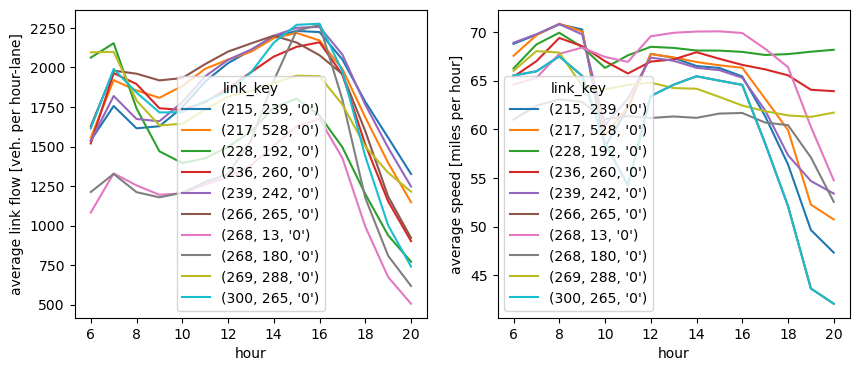

In [20]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(x= 'hour', y = 'counts_lane', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['counts_lane']].mean().reset_index(),
             ax = axs[0])
axs[0].set_ylabel('average link flow [veh. per hour-lane]')

sns.lineplot(x= 'hour', y = 'speed_avg', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])
axs[1].set_ylabel('average speed [miles per hour]')

plt.show()

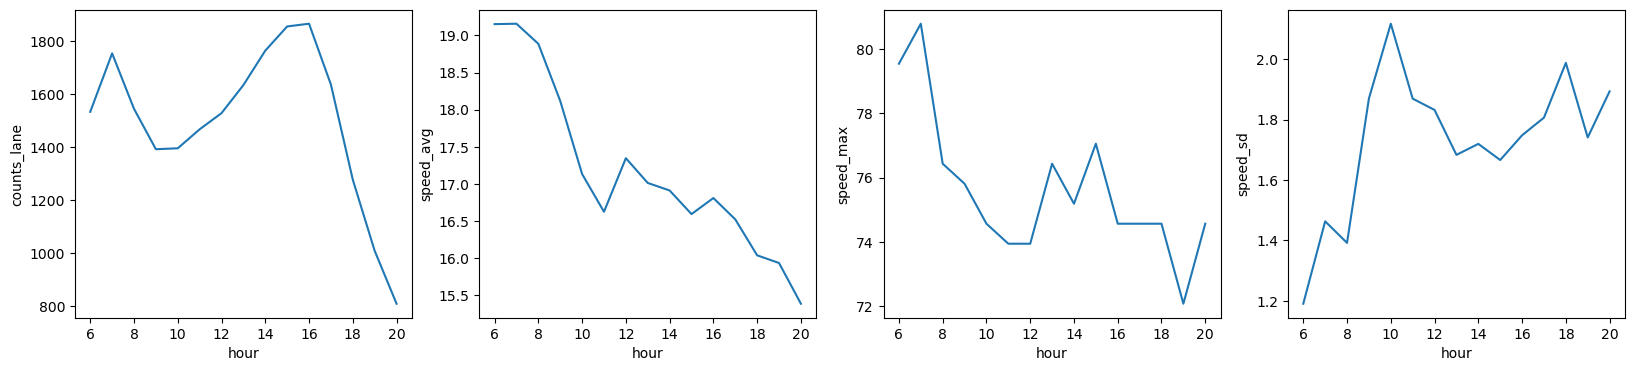

In [21]:
# Analysis for links where link counts are reported
#eda_subset_df = eda_df[~eda_df.counts.isna()].copy()
eda_subset_df = eda_df[eda_df.date == '2019-10-01'].copy()

fig, axs = plt.subplots(1,4, figsize = (20,4))

sns.lineplot(x= 'hour', y = 'counts_lane', data =eda_subset_df.groupby(['hour'])[['counts_lane']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg',
             data =eda_subset_df.groupby(['hour'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'hour', y = 'speed_max',
             data =eda_subset_df.groupby(['hour'])[['speed_max']].max().reset_index(),
             ax = axs[2])

sns.lineplot(x= 'hour', y = 'speed_sd',
             data =eda_subset_df.groupby(['hour'])[['speed_sd']].mean().reset_index(),
             ax = axs[3])

plt.show()

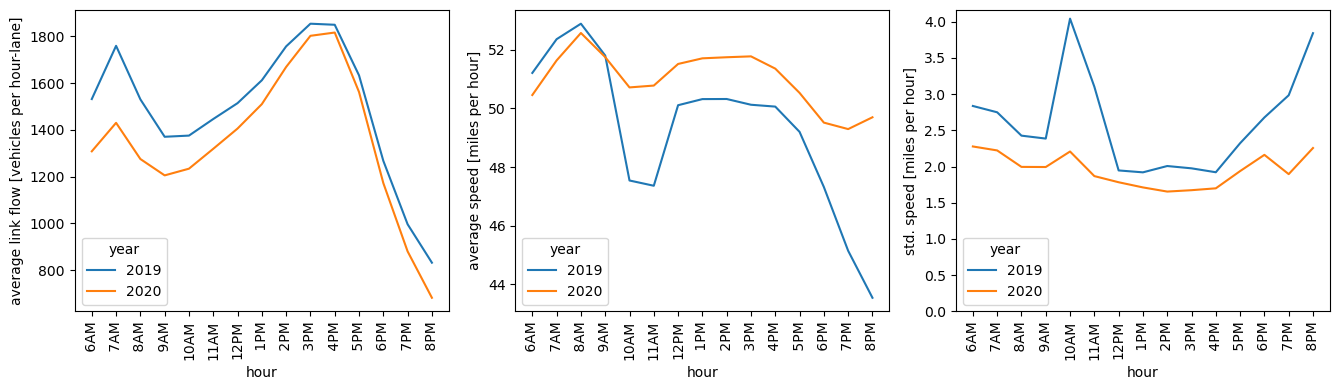

In [22]:
# Analysis for links where link counts are reported
# Hist Av Speed(km/hour)

eda_df['rr'] =eda_df['speed_sd']/ eda_df['speed_avg']

fig, axs = plt.subplots(1,3, figsize = (13.5,4), tight_layout = True)

sns.lineplot(x= 'hour_id', y = 'counts_lane', data =eda_df.groupby(['year','hour_id'])[['counts_lane']].mean().reset_index(),
             ax = axs[0], hue = 'year', palette = sns.color_palette("tab10")[0:2])

sns.lineplot(x= 'hour_id', y = 'speed_avg',
             data =eda_df[~eda_df.counts_lane.isna()].groupby(['year','hour_id'])[['speed_avg']].mean().reset_index(),
             ax = axs[1], hue = 'year', palette = sns.color_palette("tab10")[0:2])
# sns.lineplot(x= 'hour_id', y = 'rr',
#              data =eda_df[~eda_df.counts_lane.isna()].groupby(['year','hour_id'])[['rr']].mean().reset_index(),
#              ax = axs[2], hue = 'year', palette = sns.color_palette("tab10")[0:2])
sns.lineplot(x= 'hour_id', y = 'speed_sd',
             data =eda_df[~eda_df.counts_lane.isna()].groupby(['year','hour_id'])[['speed_sd']].mean().reset_index(),
             ax = axs[2], hue = 'year', palette = sns.color_palette("tab10")[0:2])

fig.autofmt_xdate(rotation = 90, ha = 'center')

axs[0].set_ylabel('average link flow [vehicles per hour-lane]')
axs[1].set_ylabel('average speed [miles per hour]')
axs[2].set_ylabel('std. speed [miles per hour]')
#axs[2].set_ylabel('avg. speed / std. speed')
axs[2].set_ylim(bottom = 0)

list(map(lambda x: x.set_xlabel('hour'),axs))
list(map(lambda x: x.legend(loc = 'lower left', title = 'year'),axs))

plt.savefig('output/figures/results/fresno-hourly-eda.png')

plt.show()



### Analyze single file of inrix data

In [23]:
inrix_df = pd.read_csv(f"{os.getcwd()}/input/private/inrix/2020-10-01.csv")
inrix_df['ts'] = pd.to_datetime(inrix_df['UTC Date Time'])
inrix_df['hour'] = inrix_df.ts.dt.hour
inrix_df['speed'] = inrix_df['Speed(km/hour)']*0.62137119223

In [24]:
# Select data from same time range
inrix_df = inrix_df[inrix_df.hour.isin(range(4,23))]

In [25]:
inrix_df.head()

,Date Time,Segment ID,UTC Date Time,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,Road Closure,Corridor/Region Name,ts,hour,speed
4,2020-10-01,1626763236,2020-10-01 04:00:00,52.0,48.0,42.0,0.13,90.0,100.0,0.0,0.0,F,Fresno_CA,2020-10-01 04:00:00,4,32.311302
5,2020-10-01,1626763236,2020-10-01 04:15:00,51.0,47.0,42.0,0.15,90.0,53.0,47.0,0.0,F,Fresno_CA,2020-10-01 04:15:00,4,31.689931
6,2020-10-01,1626763236,2020-10-01 04:30:00,47.0,47.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:30:00,4,29.204446
7,2020-10-01,1626763236,2020-10-01 04:45:00,45.0,45.0,42.0,0.17,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:45:00,4,27.961704
8,2020-10-01,1626763236,2020-10-01 05:00:00,48.0,48.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 05:00:00,5,29.825817


In [26]:
inrix_df.describe()

,Segment ID,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,hour,speed
count,1.020604e+06,1.020300e+06,940434.000000,1.020604e+06,1.020300e+06,705930.000000,1.020300e+06,1.020300e+06,1.020300e+06,1.020604e+06,1.020300e+06
mean,7.942554e+08,5.513983e+01,54.284333,5.593239e+01,4.545113e-01,95.063257,6.403537e+01,2.810540e+01,7.859205e+00,1.300000e+01,3.426230e+01
std,6.271538e+08,2.324176e+01,23.336311,2.250260e+01,4.023858e-01,5.040026,4.606894e+01,4.291665e+01,2.655070e+01,5.477228e+00,1.444176e+01
min,1.684284e+08,6.000000e+00,6.000000,1.000000e+01,0.000000e+00,50.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,3.728227e+00
25%,3.999621e+08,3.900000e+01,37.000000,4.000000e+01,1.300000e-01,90.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,2.423348e+01
50%,4.416791e+08,4.900000e+01,48.000000,5.000000e+01,3.500000e-01,96.670000,1.000000e+02,0.000000e+00,0.000000e+00,1.300000e+01,3.044719e+01
75%,1.626652e+09,7.100000e+01,71.000000,7.100000e+01,6.700000e-01,100.000000,1.000000e+02,8.000000e+01,0.000000e+00,1.800000e+01,4.411735e+01
max,1.626775e+09,1.220000e+02,122.000000,1.140000e+02,8.170000e+00,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,2.200000e+01,7.580729e+01


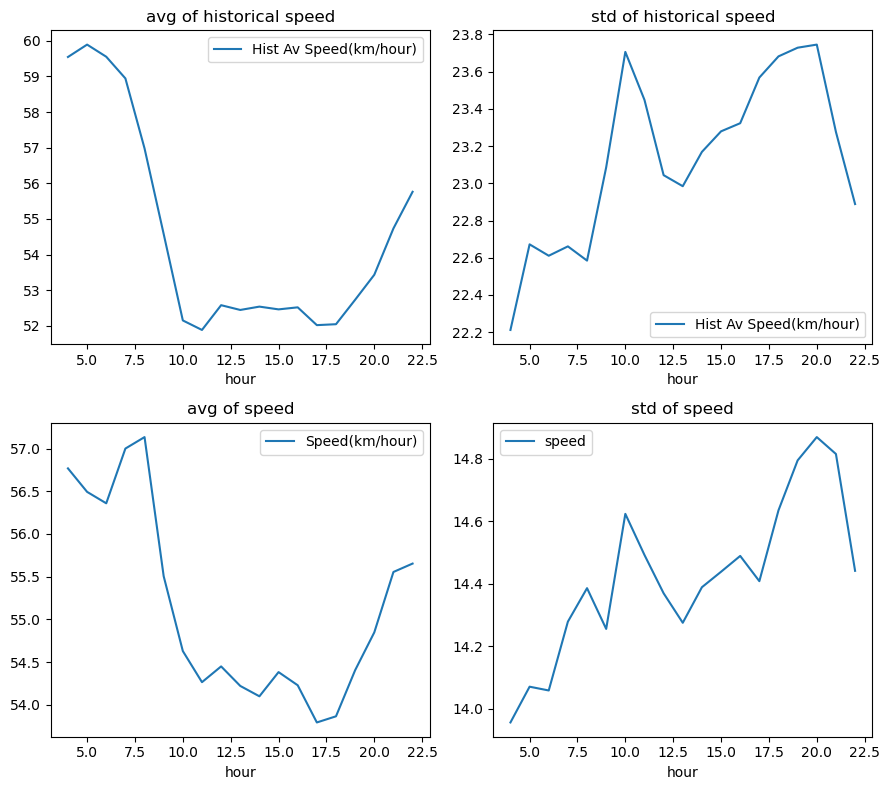

In [27]:
fig, axs = plt.subplots(2,2, figsize = (9,8), tight_layout = True)

sns.lineplot(data = inrix_df.groupby('hour')[['Hist Av Speed(km/hour)']].mean(),
             ax = axs[0,0])

axs[0,0].set_title('avg of historical speed')

sns.lineplot(data = inrix_df.groupby('hour')[['Hist Av Speed(km/hour)']].std(),
             ax = axs[0,1])
axs[0,1].set_title('std of historical speed');

sns.lineplot(data = inrix_df.groupby('hour')[['Speed(km/hour)']].mean(),
             ax = axs[1,0])

axs[1,0].set_title('avg of speed')

sns.lineplot(data = inrix_df.groupby('hour')[['speed']].std(),
             ax = axs[1,1])
axs[1,1].set_title('std of speed');

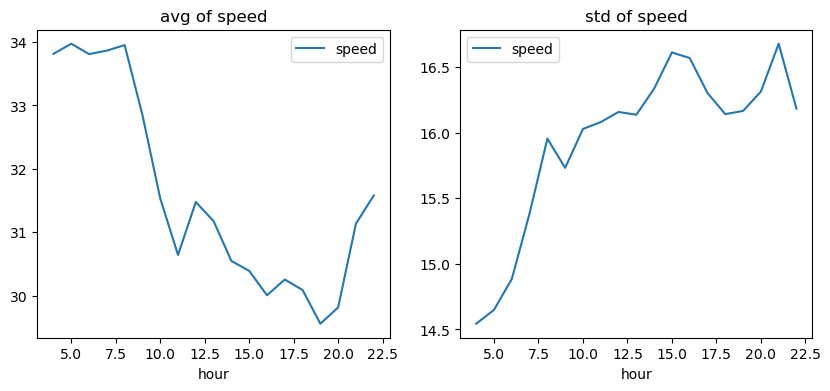

In [28]:
# Filter only data from inrix segments that were matched with the network links

fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].mean(),
             ax = axs[0])
axs[0].set_title('avg of speed')

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].std(),
             ax = axs[1])
axs[1].set_title('std of speed');